In [21]:
%pip install git+https://github.com/mcdermottLab/pycochleagram

  Cloning https://github.com/mcdermottLab/pycochleagram to /tmp/pip-req-build-zqd64p99
  Running command git clone --filter=blob:none --quiet https://github.com/mcdermottLab/pycochleagram /tmp/pip-req-build-zqd64p99
  Resolved https://github.com/mcdermottLab/pycochleagram to commit 38548920befa6bf5a9c60fc1386e6bb15953e871
  Preparing metadata (setup.py) ... done


In [22]:
!git clone https://github.com/mcdermottLab/pycochleagram

fatal: destination path 'pycochleagram' already exists and is not an empty directory.


In [32]:
%pip install pyaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 999.1 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyaudio
Failed to build pyaudio
ERROR: Could not build wheels for pyaudio, which is required to install pyproject.toml-based projects


In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
from random import choice
from time import sleep, time
import numpy as np
from scipy.signal import welch, decimate

from pycochleagram import cochleagram as cgram
from pycochleagram import erbfilter as erb
from pycochleagram import utils

In [24]:
if utils.check_if_display_exists():
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import imshow, show
else:
  import matplotlib
  matplotlib.use('Agg')
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import imshow, show

In [25]:
def demo_human_cochleagram_helper(signal, sr, n, sample_factor=2, downsample=None, nonlinearity=None):
  """Demo the cochleagram generation.

    signal (array): If a time-domain signal is provided, its
      cochleagram will be generated with some sensible parameters. If this is
      None, a synthesized tone (harmonic stack of the first 40 harmonics) will
      be used.
    sr: (int): If `signal` is not None, this is the sampling rate
      associated with the signal.
    n (int): number of filters to use.
    sample_factor (int): Determines the density (or "overcompleteness") of the
      filterbank. Original MATLAB code supported 1, 2, 4.
    downsample({None, int, callable}, optional): Determines downsampling method to apply.
      If None, no downsampling will be applied. If this is an int, it will be
      interpreted as the upsampling factor in polyphase resampling
      (with `sr` as the downsampling factor). A custom downsampling function can
      be provided as a callable. The callable will be called on the subband
      envelopes.
    nonlinearity({None, 'db', 'power', callable}, optional): Determines
      nonlinearity method to apply. None applies no nonlinearity. 'db' will
      convert output to decibels (truncated at -60). 'power' will apply 3/10
      power compression.

    Returns:
      array:
        **cochleagram**: The cochleagram of the input signal, created with
          largely default parameters.
  """
  human_coch = cgram.human_cochleagram(signal, sr, n=n, sample_factor=sample_factor,
      downsample=downsample, nonlinearity=nonlinearity, strict=False)
  img = np.flipud(human_coch)  # the cochleagram is upside down (i.e., in image coordinates)
  return img

In [26]:
def make_harmonic_stack(f0=100, n_harm=40, dur=0.25001, sr=20000, low_lim=50, hi_lim=20000, n=None):
  """Synthesize a tone created with a stack of harmonics.

  Args:
    f0 (int, optional): Fundamental frequency.
    n_harm (int, optional): Number of harmonics to include.
    dur (float, optional): Duration, in milliseconds. Note, the default value
      was chosen to create a signal length that is compatible with the
      predefined downsampling method.
    sr (int, optional): Sampling rate.
    low_lim (int, optional): Lower limit for filterbank.
    hi_lim (int, optional): Upper limit for filerbank.
    n (None, optional): Number of filters in filterbank.

  Returns:
    tuple:
      **signal** (array): Synthesized tone.
      **signal_params** (dict): A dictionary containing all of the parameters
        used to synthesize the tone.
  """
  # i don't know where this came from, but choose a number of filters
  if n is None:
    n = int(np.floor(erb.freq2erb(hi_lim) - erb.freq2erb(low_lim)) - 1)

  # synthesize tone from harmonic stack
  t = np.arange(0, dur + 1 / sr, 1 / sr)
  signal = np.zeros_like(t)
  for i in range(1, n_harm + 1):
    signal += np.sin(2 * np.pi * f0 * i * t)  # zero-phase

  # store all the params in a dictionary
  signal_params = {
      'f0': f0,
      'n_harm': n_harm,
      'dur': dur,
      'sr': sr,
      'low_lim': low_lim,
      'hi_lim': hi_lim,
      'n': n
  }

  return signal, signal_params

In [27]:
### Cochleagram Generation from Waveform ###
def demo_human_cochleagram(signal=None, sr=None, n=None):
  """Demo to generate the human cochleagrams, displaying various nonlinearity
  and downsampling options. If a signal is not provided, a tone synthesized
  with 40 harmonics and an f0=100 will be used.

  Args:
    signal (array, optional): Signal containing waveform data.
    sr (int, optional): Sampling rate of the input signal.
    n (int, optional): Number of filters to use in the filterbank.

  Returns:
    None
  """
  # get a signal if one isn't provided
  if signal is None:
    signal, signal_params = make_harmonic_stack()
    sr = signal_params['sr']
    n = signal_params['n']
  else:
    assert sr is not None
    assert n is not None

  ### Demo Cochleagram Generation with Predefined Nonlinearities ###
  # no nonlinearity
  coch = demo_human_cochleagram_helper(signal, sr, n, nonlinearity=None)
  # convert to decibel
  coch_log = demo_human_cochleagram_helper(signal, sr, n, nonlinearity='db')
  # 3/10 power compression
  coch_pow = demo_human_cochleagram_helper(signal, sr, n, nonlinearity='power')

  plt.subplot(321)
  plt.title('Signal waveform')
  plt.plot(signal)
  plt.ylabel('amplitude')
  plt.xlabel('time')

  plt.subplot(323)
  plt.title('Signal Frequency Content')
  f, Pxx_den = welch(signal.flatten(), sr, nperseg=1024)
  plt.semilogy(f, Pxx_den)
  plt.xlabel('frequency [Hz]')
  plt.ylabel('PSD [V**2/Hz]')

  plt.subplot(322)
  plt.title('Cochleagram with no nonlinearity')
  plt.ylabel('filter #')
  plt.xlabel('time')
  utils.cochshow(np.flipud(coch), interact=False)
  plt.gca().invert_yaxis()

  plt.subplot(324)
  plt.title('Cochleagram with nonlinearity: "log"')
  plt.ylabel('filter #')
  plt.xlabel('time')
  utils.cochshow(np.flipud(coch_log), interact=False)
  plt.gca().invert_yaxis()

  plt.subplot(326)
  plt.title('Cochleagram with nonlinearity: "power"')
  plt.ylabel('filter #')
  plt.xlabel('time')
  utils.cochshow(np.flipud(coch_pow), interact=False)
  plt.gca().invert_yaxis()
  plt.tight_layout()

  ### Demo Cochleagram Generation with Downsampling ###
  plt.figure()
  # no downsampling
  # cochd = demo_human_cochleagram_helper(signal, sr, n, downsample=None)
  # predefined polyphase resampling with upsample factor = 10000, downsample factor = `sr`
  cochd_poly = demo_human_cochleagram_helper(signal, sr, n, downsample=10000)
  # custom downsampling function to use decimate with a downsampling factor of 2
  custom_downsample_fx = lambda x: decimate(x, 2, axis=1, ftype='fir', zero_phase=True)
  cochd_decimate = demo_human_cochleagram_helper(signal, sr, n, downsample=custom_downsample_fx)

  plt.subplot(221)
  plt.title('Signal waveform')
  plt.plot(signal)
  plt.ylabel('amplitude')
  plt.xlabel('time')

  plt.subplot(223)
  plt.title('Signal Frequency Content')
  f, Pxx_den = welch(signal.flatten(), sr, nperseg=1024)
  plt.semilogy(f, Pxx_den)
  plt.xlabel('frequency [Hz]')
  plt.ylabel('PSD [V**2/Hz]')

  plt.subplot(222)
  plt.title('Cochleagram with 2x default\n(polyphase) downsampling')
  plt.ylabel('filter #')
  plt.xlabel('time')
  utils.cochshow(np.flipud(cochd_poly), interact=False)
  plt.gca().invert_yaxis()

  plt.subplot(224)
  plt.title('Cochleagram with 2x custom\n(decimate) downsampling')
  plt.ylabel('filter #')
  plt.xlabel('time')
  utils.cochshow(np.flipud(cochd_decimate), interact=False)
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()


In [28]:
def demo_playback(signal, sr, ignore_warning=False):
  """Demo audio playback with pyaudio.

  Args:
    signal (array, optional): Signal containing waveform data.
    sr (int, optional): Sampling rate of the input signal.
    ignore_warning (bool, optional): Determines if audio signals will be played
      (using pyaudio). NOTE: Be careful with the volume when using playback,
      things can get *very loud*.

  Returns:
    None
  """
  # get a signal if one isn't provided
  if signal is None:
    signal, signal_params = make_harmonic_stack()
    sr = signal_params['sr']
  else:
    assert sr is not None

  # audio playback
  pyaudio_params={'channels': utils.get_channels(signal),
                  'rate': sr,
                  'output': True,
                  'output_device_index': 1}
  print(signal.shape)
  utils.play_array(signal, pyaudio_params=pyaudio_params, ignore_warning=ignore_warning)

In [29]:
### Waveform Generation from Cochleagram (Inversion) ###
def demo_invert_cochleagram(signal=None, sr=None, n=None, playback=False):
  """Demo that will generate a cochleagram from a signal, then invert this
  cochleagram to produce a waveform signal.

  Args:
    signal (array, optional): Signal containing waveform data.
    sr (int, optional): Sampling rate of the input signal.
    n (int, optional): Number of filters to use in the filterbank.
    playback (bool, optional): Determines if audio signals will be played
      (using pyaudio). If False, only plots will be created. If True, the
      original signal and inverted cochleagram signal will be played. NOTE:
      Be careful with the volume when using playback, things can get
      *very loud*.

  Returns:
    None
  """
  # get a signal if one isn't provided
  if signal is None:
    signal, signal_params = make_harmonic_stack()
    sr = signal_params['sr']
    n = signal_params['n']
    low_lim = signal_params['low_lim']
    hi_lim = signal_params['hi_lim']
  else:
    assert sr is not None
    assert n is not None
    low_lim = 50  # this is the default for cochleagram.human_cochleagram
    hi_lim = 20000  # this is the default for cochleagram.human_cochleagram

  # generate a cochleagram from the signal
  sample_factor = 2  # this is the default for cochleagram.human_cochleagram
  coch = demo_human_cochleagram_helper(signal, sr, n, sample_factor=sample_factor)
  print('Generated cochleagram with shape: ', coch.shape)

  # invert the cochleagram to get a signal
  coch = np.flipud(coch)  # the ouput of demo_human_cochleagram_helper is flipped
  inv_coch_sig, inv_coch = cgram.invert_cochleagram(coch, sr, n, low_lim, hi_lim, sample_factor, n_iter=10, strict=False)

  print('Generated inverted cochleagram')
  print('Original signal shape: %s, Inverted cochleagram signal shape: %s' % (signal.shape, inv_coch_sig.shape))

  plt.subplot(211)
  plt.title('Cochleagram of original signal')
  utils.cochshow(coch, interact=False)  # this signal is already flipped
  plt.ylabel('filter #')
  plt.xlabel('time')
  plt.gca().invert_yaxis()

  plt.subplot(212)
  plt.title('Cochleagram of inverted signal')
  utils.cochshow(inv_coch, interact=False)  # this signal needs to be flipped
  plt.ylabel('filter #')
  plt.xlabel('time')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

  if playback:
    print('playing original signal...')
    utils.play_array(signal, pyaudio_params={'rate': sr}, ignore_warning=True)
    sleep(1)
    print('playing inverted cochleagram signal...')
    utils.play_array(inv_coch_sig, pyaudio_params={'rate': sr}, ignore_warning=True)

In [30]:
def main(ignore_playback_warning=False, mode='rand_sound'):
  """Run all demo functions.

  Args:
    ignore_playback_warning (bool, optional): To use audio playback, you must
      acknowledge that things can get *very loud* by setting
      `ignore_playback_warning` to True.
    mode ({'rand_sound', other}): Set the mode for the demo. If this is
      'rand_sound', a sound from the demo_stim/ directory will be chosen
      at random and used for the demos. If this is anything else, a harmonic
      stack of 40 harmonics and an f0=100Hz will be generated and used.

  Returns:
    None
  """
  mode = mode.lower()
  from os.path import dirname, join, realpath
  DEMO_PATH = join('pycochleagram/pycochleagram', 'demo_stim')
  if mode == 'rand_sound':
    rfn = choice([os.path.join(DEMO_PATH, f)for f in os.listdir(DEMO_PATH) if f.endswith('.wav')])
    print(os.listdir(DEMO_PATH))
    # rfn = [os.path.join(DEMO_PATH, f)for f in os.listdir(DEMO_PATH)][1]
    print('Running demo with sound file: %s ' % rfn)
    demo_stim, demo_sr = utils.wav_to_array(rfn)
    demo_n = 38  # default filter for low_lim=50 hi_lim=20000
  elif mode == 'batch':
    demo_stim = np.load('demo_stim/wavs_speech_n10_2s_16k.npy')
    demo_sr = 16000
    demo_n = 38  # default filter for low_lim=50 hi_lim=20000
    start_time = time()
    demo_human_cochleagram_helper(demo_stim, demo_sr, demo_n, downsample=200, nonlinearity='power')
    total_time = time() - start_time
    print('Improved Batch --> %s, %ss per coch' % (total_time, total_time / 10))
    return
  elif mode == 'naive_batch':
    demo_stim = np.load('demo_stim/wavs_speech_n10_2s_16k.npy')
    demo_sr = 16000
    demo_n = 38  # default filter for low_lim=50 hi_lim=20000
    start_time = time()
    for i in range(demo_stim.shape[0]):
      # print('%s/%s' % (i+1, demo_stim.shape[0]))
      temp_signal = demo_stim[i]
      demo_human_cochleagram_helper(temp_signal, demo_sr, demo_n, downsample=200, nonlinearity='power')
    total_time = time() - start_time
    print('Naive Batch --> %s, %ss per coch' % (total_time, total_time / 10))
    return
  else:
    demo_stim, demo_sr, demo_n = None, None, None

  print('\n### DEMO: COCHLEAGRAM GENERATION ###')
  print('====================================')
  demo_human_cochleagram(demo_stim, demo_sr, demo_n)

  print('\n### DEMO: AUDIO PLAYBACK ###')
  print('============================')
  demo_playback(demo_stim, demo_sr, ignore_warning=ignore_playback_warning)

  print('\n### DEMO: COCHLEAGRAM INVERSION ###\n')
  print('===================================')
  demo_invert_cochleagram(demo_stim, demo_sr, demo_n, playback=ignore_playback_warning)

['stim34_blues_band.wav', 'sa1.wav', 'wavs_speech_n10_2s_16k.npy', 'stim108_telephone_dialing.wav', 'stim107_dial_tone.wav']
Running demo with sound file: pycochleagram/pycochleagram/demo_stim/stim107_dial_tone.wav 

### DEMO: COCHLEAGRAM GENERATION ###
here


/usr/local/lib/python3.10/dist-packages/pycochleagram/cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


here
here
here
here


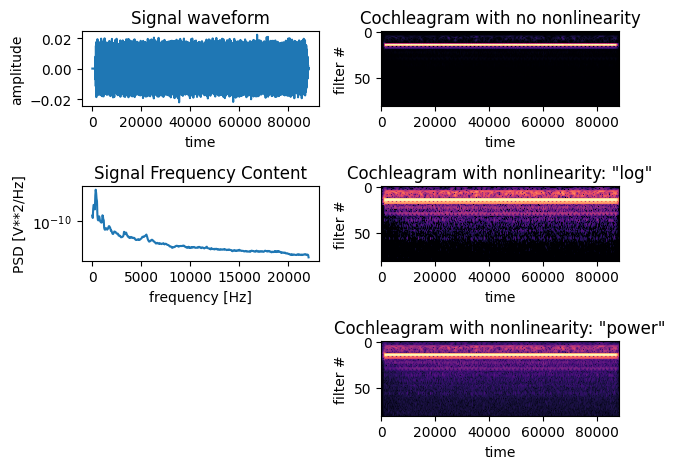

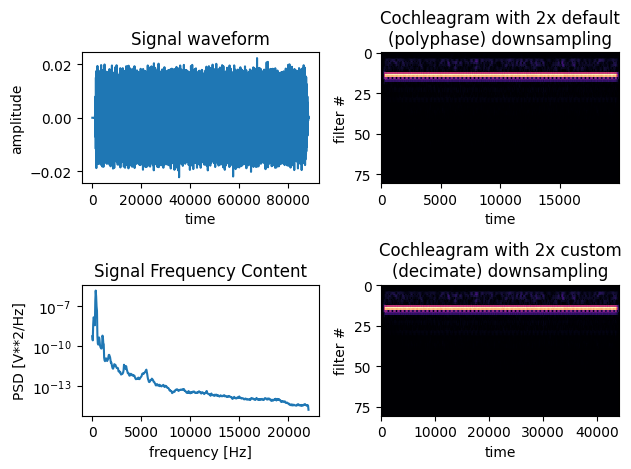


### DEMO: AUDIO PLAYBACK ###
(88200,)


ModuleNotFoundError: No module named 'pyaudio'

In [33]:
main()